# Imports

In [14]:
# Common
import pandas as pd
import tensorflow as tf
from glob import glob
import numpy as np
import os

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam


# Metrics
from tensorflow.keras.metrics import *

# Exploring the data

In [16]:
benign_path = "Dataset_BUSI_with_GT/benign"
malignant_path = "Dataset_BUSI_with_GT/malignant"
normal_path = "Dataset_BUSI_with_GT/normal"

benign_df = os.listdir(benign_path)
malignant_df = os.listdir(malignant_path)
normal_df = os.listdir(normal_path)

print(f'\033[92m')
print(f"'normal' class has {len([i for i in normal_df if 'normal' in i and 'mask' not in i])} images and {len([i for i in normal_df if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in benign_df if 'benign' in i and 'mask' not in i])} images and {len([i for i in benign_df if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in malignant_df if 'malignant' in i and 'mask' not in i])} images and {len([i for i in malignant_df if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are a total of {len([i for i in benign_df + malignant_df + normal_df if 'mask' not in i])} images and {len([i for i in benign_df + malignant_df + normal_df if 'mask' in i])} masks.")



'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are a total of 780 images and 798 masks.


# Loading the data

In [17]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)


In [18]:
def load_image(path, size):
    image = cv2.imread(path)
    
    if image is None:
        print(f"Error loading image at path: {path}")
        return None
    
    image = cv2.resize(image, (size, size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # Assuming images are in BGR format
    image = image / 255.   # Normalize
    return image


In [19]:
size = 128   # image size: 128x128
absolute_path = "Dataset_BUSI_with_GT/*/*"
X, y = load_data(root_path=absolute_path, size=size)


In [20]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [21]:
# loading benign samples
framObjTrain = LoadData(framObjTrain, imgPath="Dataset_BUSI_with_GT/benign",
                        maskPath="Dataset_BUSI_with_GT/benign",
                        shape=256)


In [22]:
# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = "Dataset_BUSI_with_GT/malignant"
                        , maskPath = "Dataset_BUSI_with_GT/malignant"
                         , shape = 256)

In [23]:
# loading Normal samples

framObjTrain = LoadData( framObjTrain, imgPath = "Dataset_BUSI_with_GT/normal"
                        , maskPath = "Dataset_BUSI_with_GT/normal"
                         , shape = 256)

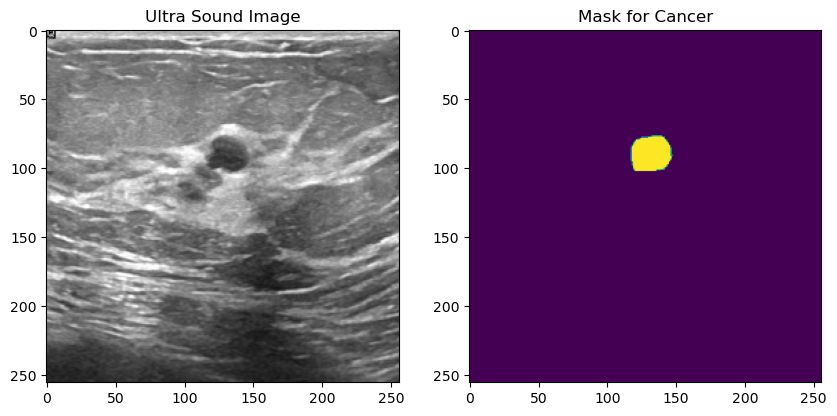

In [24]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

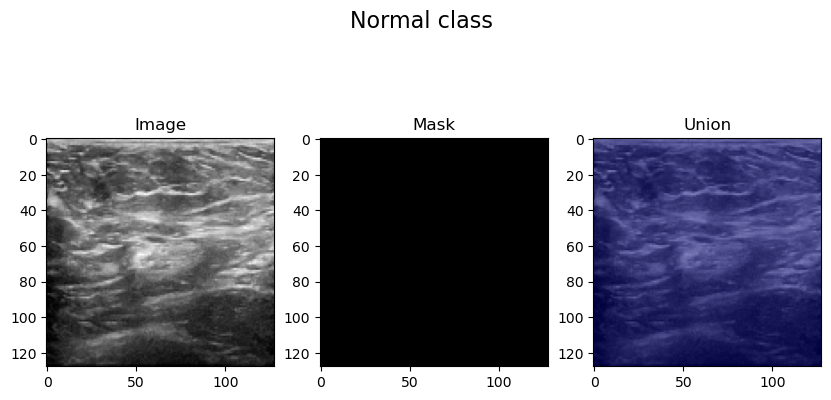

In [25]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

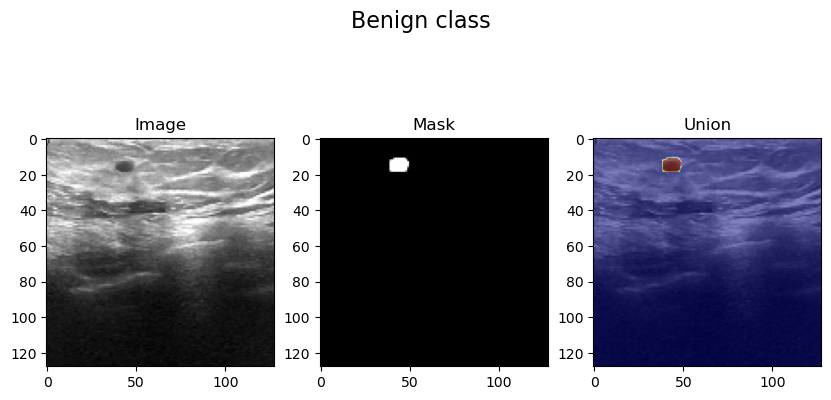

In [26]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

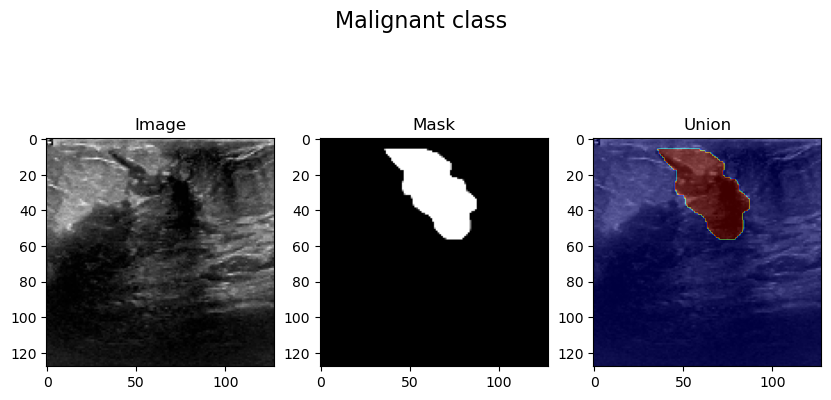

In [27]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

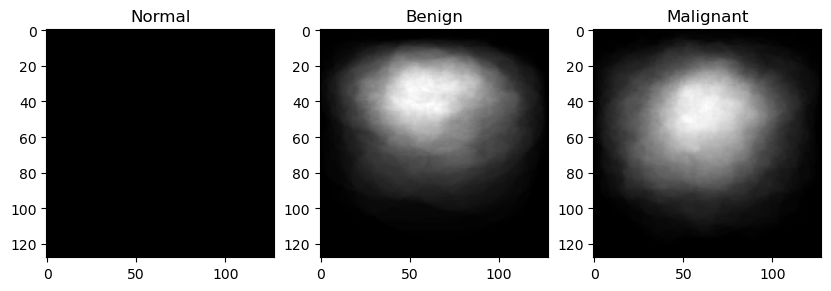

In [28]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

In [29]:
from pathlib import Path

class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = Path(datasetpath)
        self.imageShape = imageShape

    def imagesPath(self, folder, name):
        images = list((self.datasetpath / folder).glob(f'*{name}.*'))
        return images

    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            with tf.io.gfile.GFile(str(image), 'rb') as f:
                image = tf.image.decode_png(f.read(), channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image /= 255
            listImages.append(image)
        return listImages

    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name=')'), channels=3)
        masks = np.array(self.readImages(self.imagesPath(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape=(len(images_benign),)) * 0,
                            np.ones(shape=(len(images_malignant),)) * 1,
                            np.ones(shape=(len(images_normal),)) * 2])
        return images, masks, labels

    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, labels, masks):
            image1 = tf.image.adjust_contrast(image, contrast_factor=2)
            image2 = tf.image.adjust_brightness(image, delta=0.3)
            imagesupdate.append(image), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image1), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image2), masksupdate.append(mask), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)


Sample 1: Label - 0.0


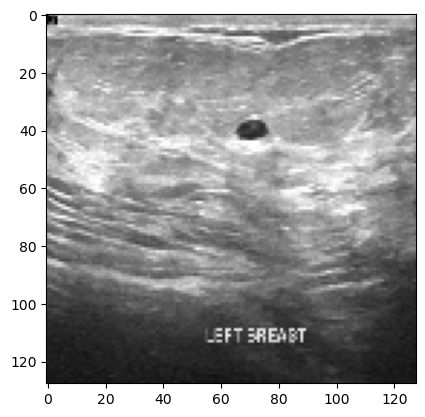

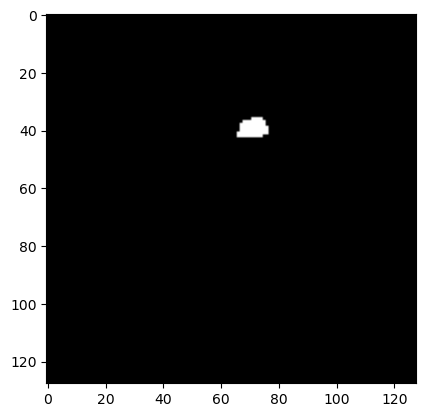

Sample 2: Label - 0.0


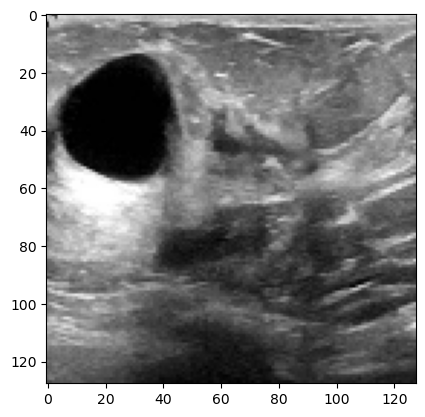

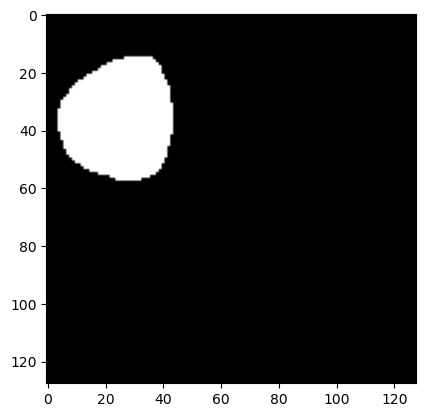

Sample 3: Label - 0.0


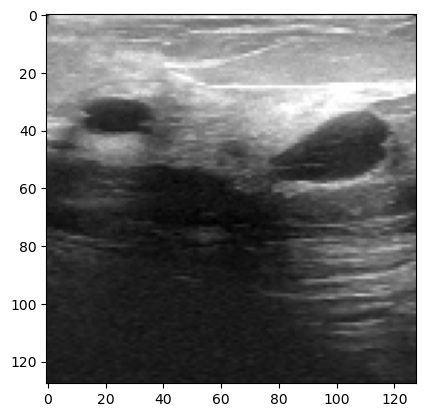

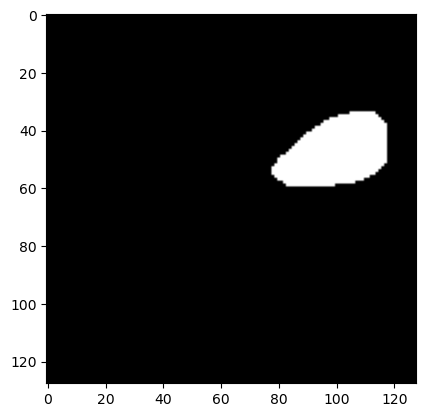

Sample 4: Label - 0.0


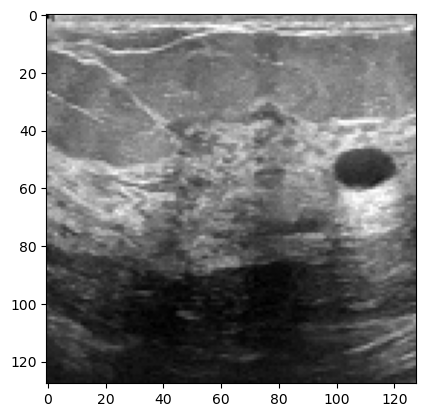

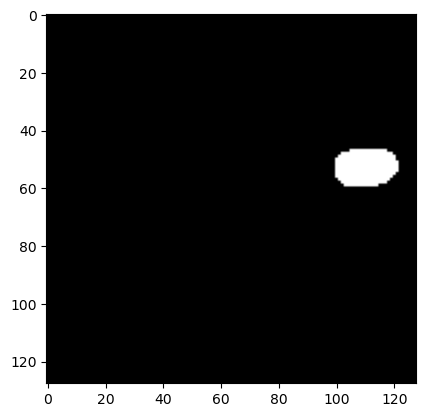

Sample 5: Label - 0.0


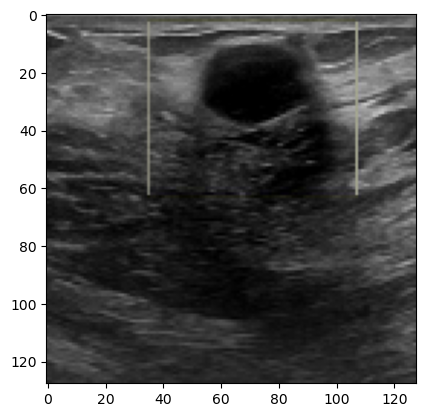

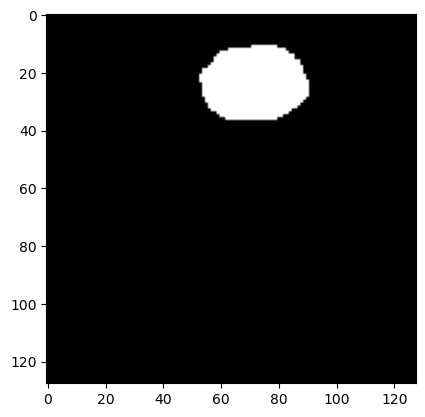

In [31]:
# Example: Load a subset of data
dataset_path = "Dataset_BUSI_with_GT"
dataset_object = readDataset(dataset_path, imageShape=(128, 128))

# Example: Load and print a few samples
images, masks, labels = dataset_object.finalDataset(['benign', 'malignant', 'normal'])

for i in range(5):  # Print the first 5 samples
    print(f"Sample {i+1}: Label - {labels[i]}")
    plt.imshow(images[i])
    plt.show()
    plt.imshow(masks[i], cmap='gray')
    plt.show()


In [32]:

datasetpath = "Dataset_BUSI_with_GT"
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

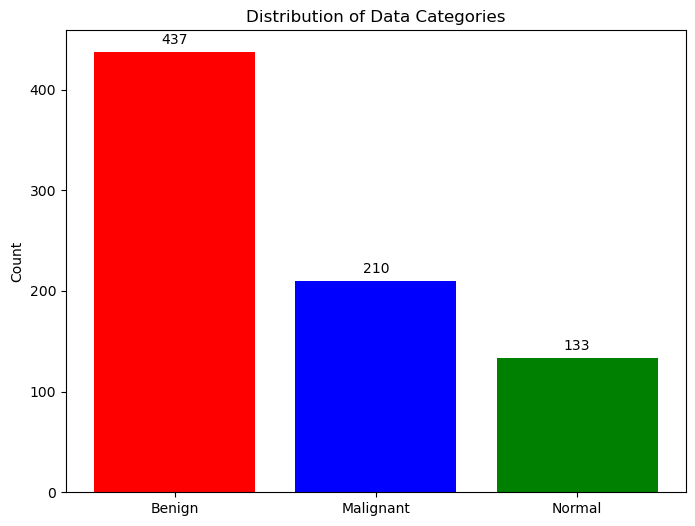

In [33]:

from collections import Counter

label_counts = Counter(labels)

categories = list(label_counts.keys())
category_counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, category_counts, color=['red', 'blue', 'green'])
plt.ylabel('Count')
plt.title('Distribution of Data Categories')

for bar, count in zip(bars, category_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom')

# Set X-axis labels
plt.xticks(categories, ['Benign', 'Malignant', 'Normal'])

plt.show()

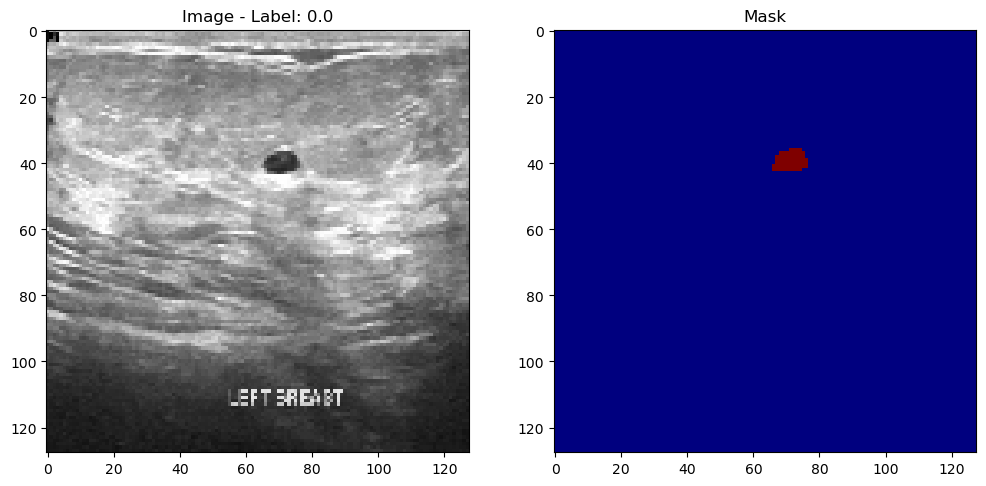

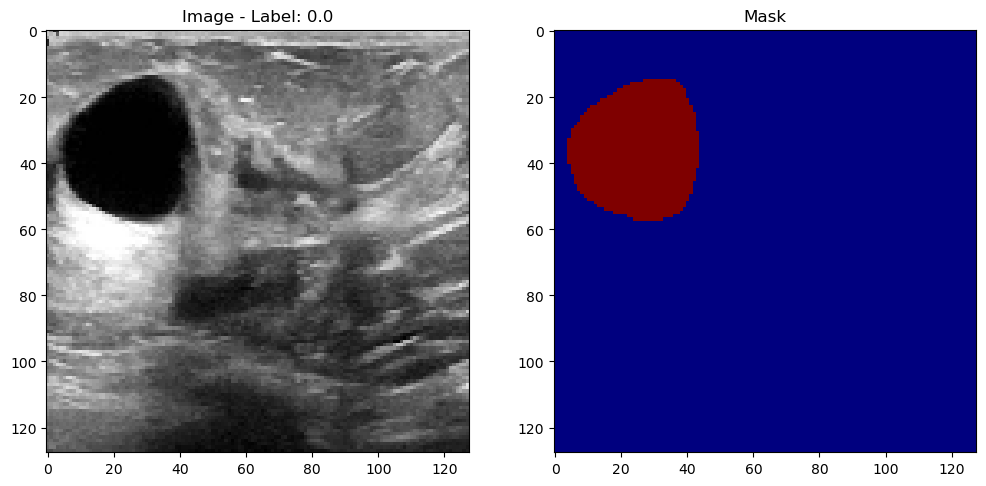

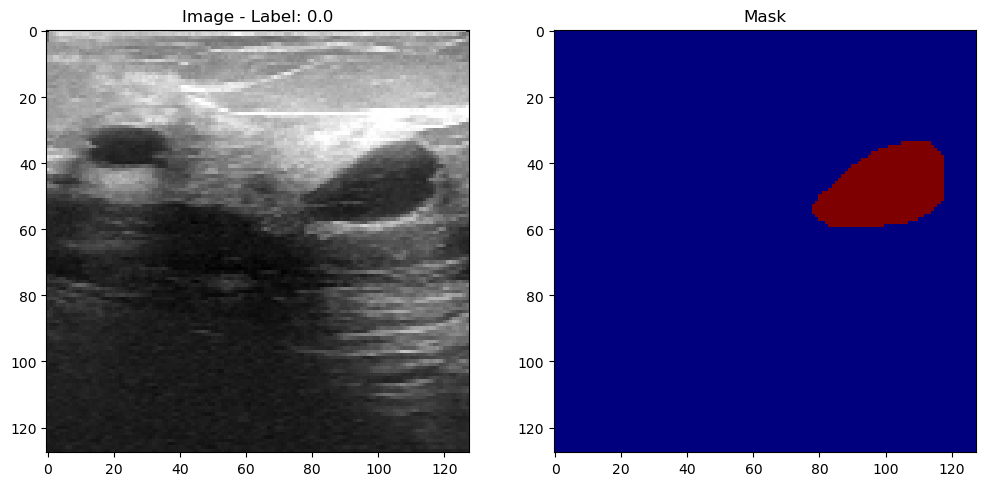

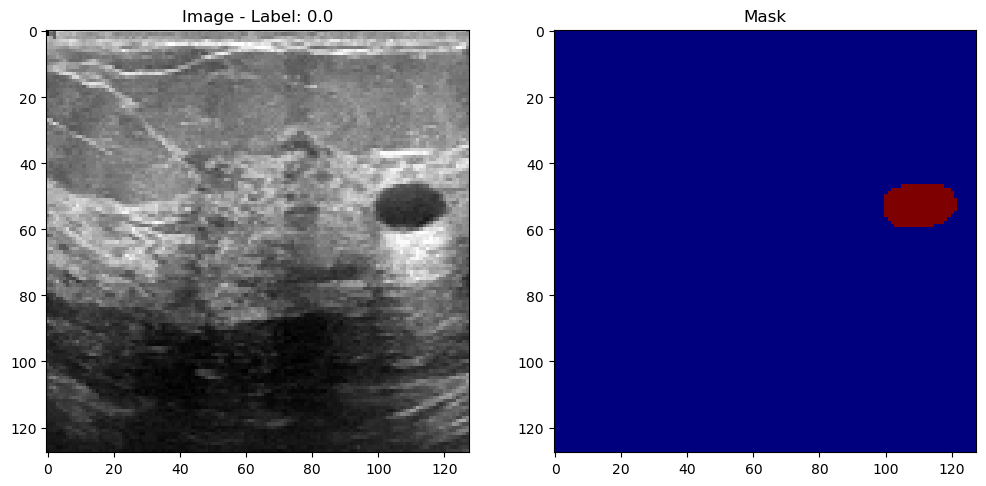

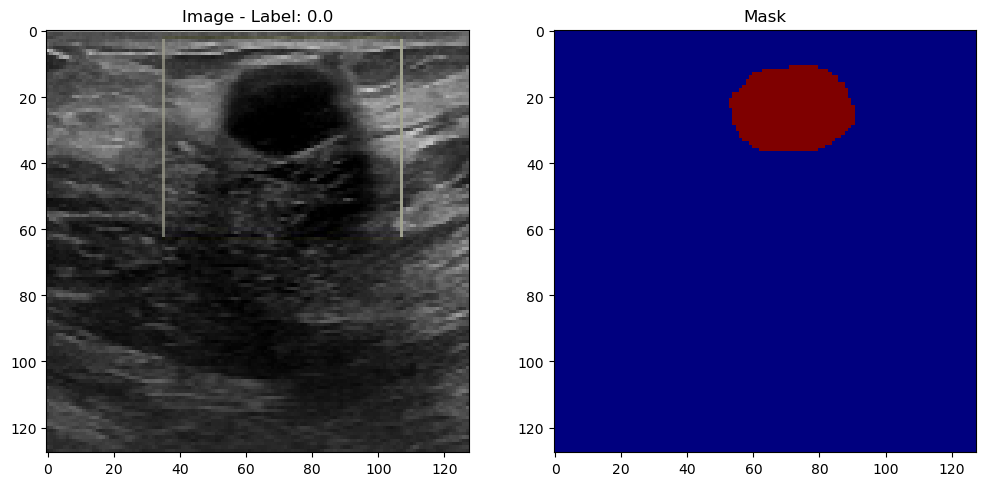

In [34]:
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))
    
    # ultrasound
    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image - Label: {labels[i]}')
    
    # mask 
    if masks is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='jet') 
        plt.title('Mask')
    
    plt.show()


In [35]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [36]:
np.unique(labels, return_counts = True)

(array([0., 1., 2.]), array([1311,  630,  399], dtype=int64))

In [37]:
def showImagesWithMask(images, masks, labels):
    plt.figure(figsize = (12, 12))
    for i in range(len(images)):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha = 0.3, cmap = 'jet')
        plt.title(labels[i])
    plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

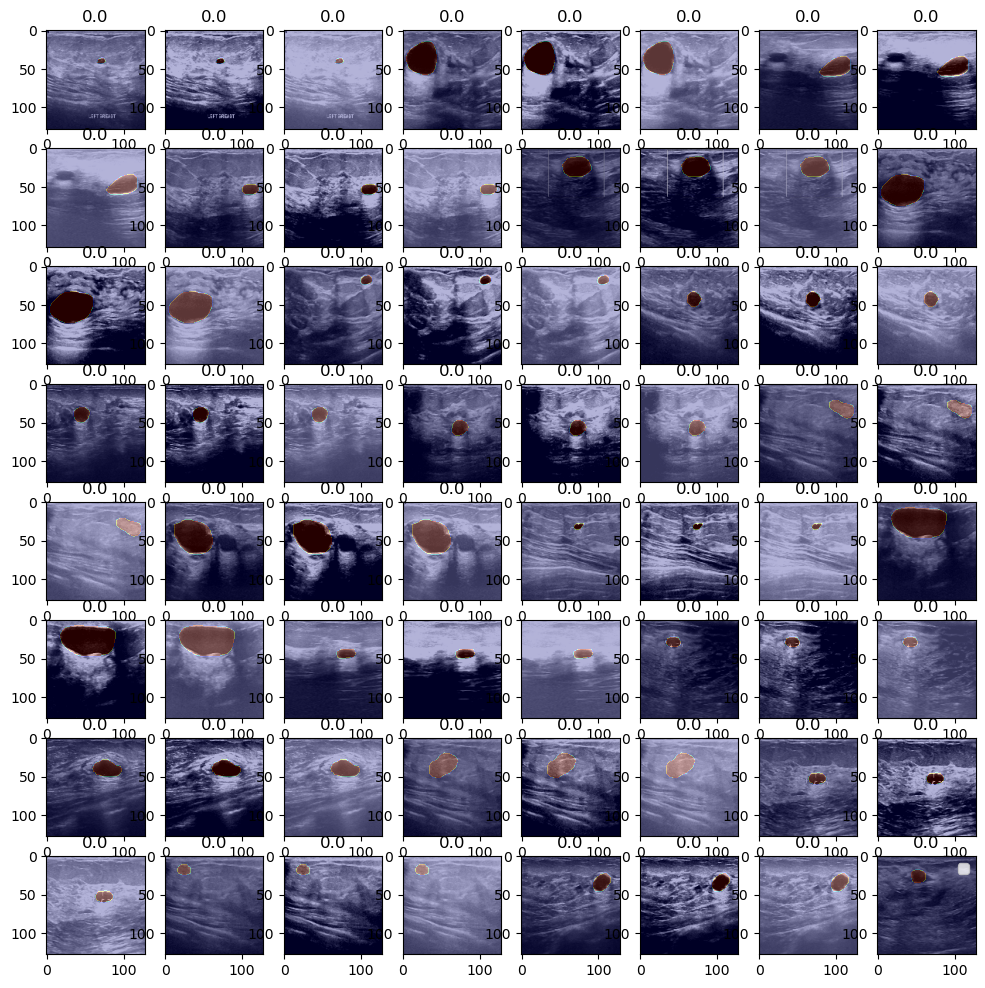

In [38]:
showImagesWithMask(images[:64], masks[:64], labels[:64])

# After splitting the dataset

In [39]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [40]:
valid = 500
trainDataset = [images[:images.shape[0] - valid], 
         masks[:images.shape[0] - valid], 
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:], 
         masks[images.shape[0] - valid:], 
         labels[images.shape[0] - valid:]]

In [41]:
trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape

((1840, 128, 128, 3), (1840, 128, 128, 1), (1840,))

In [42]:
validDataset[0].shape, validDataset[1].shape, validDataset[2].shape

((500, 128, 128, 3), (500, 128, 128, 1), (500,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

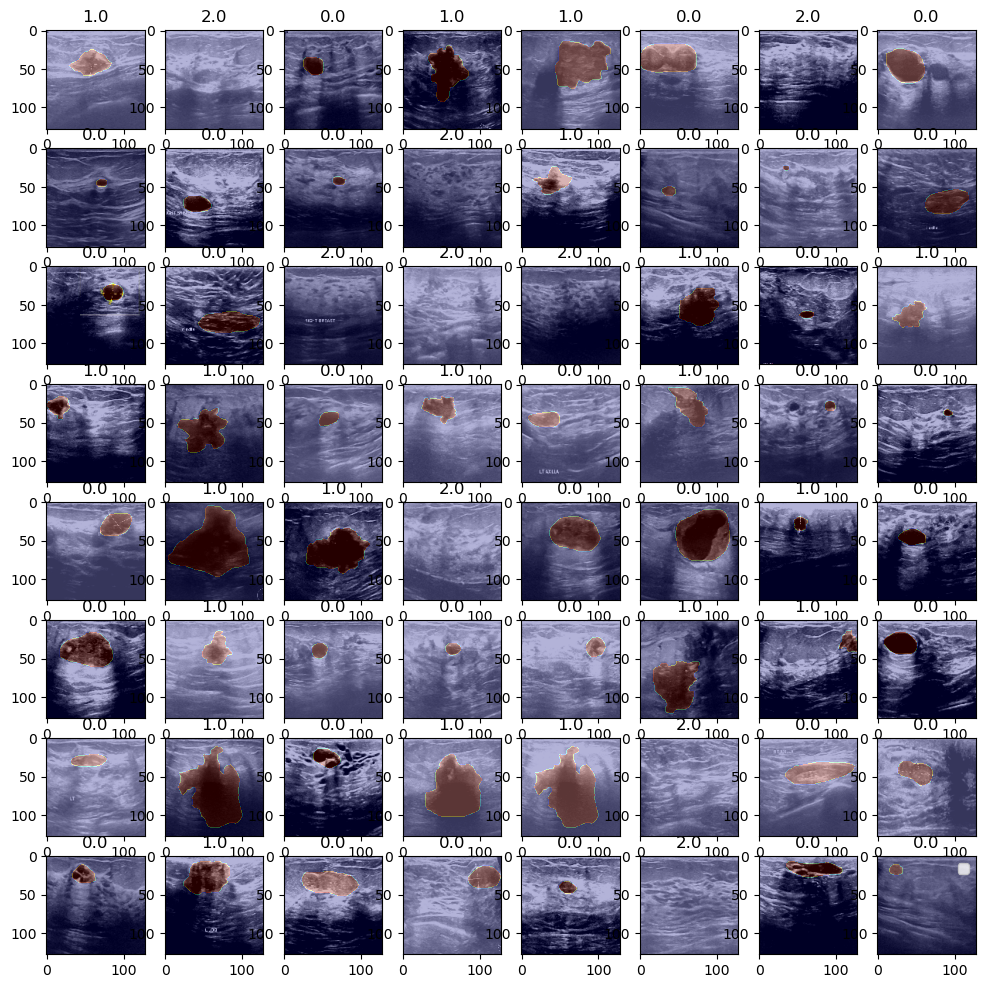

In [43]:
showImagesWithMask(trainDataset[0][:64], trainDataset[1][:64], trainDataset[2][:64])